In [1]:
import numpy as np
import os
import glob
import shutil
import matplotlib.pyplot as plt
import json
import subprocess
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from IPython.display import Image
%matplotlib inline

Module for computations (if needed)

In [2]:
import FEM_utilities as FEM

# Lab 06

## 1) Lateral buckling

## Write input file - Shell

In [3]:
def write_shell_inp_file(L, h, b, num_e, y_e, E, ν, num_modes):
    """
    function to write inp file:
    L        : lenght of cantilever
    h        : height
    b        :  thickness
    num_e    : number of elements
    y_e      : number of elements in y direction
    E        : Young's modulus
    nu       : Poisson ratio
    num_modes: number of eigenvalues to be estimated
    """
    
    elname = "EALL"
    matname = "mat1"
    bcname = "fixed_nodes"
    loadextnodes = 'loaded_nodes_external'
    loadintnodes = 'loaded_nodes_internal'
    
    pa = [1.0,0.0,0.0]
    pb = [0.0,1.0,0.0]
    # pc = [0.0,0.0,0.0]
    ax = 3
    α = 0.0
    
    intpoints = 5
    
    basename = 'b1_ne'+str(num_e).zfill(3)+'_ye'+str(y_e).zfill(2)+'_aS'

    filename = basename+'.inp'
    
    outfile = open(filename, "wt")
    
    outfile.write("** Lab 06 input file buckling - shell\n")
        
    nodes, elements, fixed, loaded = FEM.Nodes(num_e, y_e, L, h)
        
    # NODES section
    outfile.write("**\n")
    outfile.write("** Nodes\n")
    outfile.write("**\n")
    outfile.write("*NODE, nset = nglobal\n")

    for i in range(nodes.shape[0]):
        nodestring = "{0:4d}".format(int(nodes[i,0]))
        for j in range(1,nodes.shape[1]):
            nodestring+=",{0:8}".format(nodes[i,j])
        nodestring+="\n"
        outfile.write(nodestring)
        
    # ELEMENTS section
    outfile.write("**\n")
    outfile.write("** Elements\n")
    outfile.write("**\n")
    outfile.write("*ELEMENT, type = S4R\n")
    
    for i in range(elements.shape[0]):
        elstring = "{0:4d}".format(int(elements[i,0]))
        for j in range(1,elements.shape[1]):
            elstring+=",{0:4d}".format(int(elements[i,j]))
        elstring+="\n"
        outfile.write(elstring)

    # MATERIAL section
    outfile.write("**\n")
    outfile.write("** Materials\n")
    outfile.write("**\n")
    outfile.write("*MATERIAL, name = {0}\n".format(matname))
    outfile.write("*Elastic\n")
    outfile.write("{0},{1:6}\n".format(E,ν))

    # SETS section
    # NODES
    outfile.write("**\n")
    outfile.write("** Sets\n")
    outfile.write("**\n")
    outfile.write("*NSET, nset = {0}\n".format(bcname))

    fix_str = "{0:4d}".format(int(fixed[0]))
    
    for i in range(1,len(fixed)):
        fix_str+=",{0:4d}".format(int(fixed[i]))
    fix_str+="\n"
    outfile.write(fix_str)
    
    # loaded
    if len(loaded > 2):
        outfile.write("*Nset, nset = {0}\n".format(loadintnodes))
        il_str = "{0:4d}".format(int(loaded[1]))
        for i in range(2,len(loaded)-1):
            il_str+=",{0:4d}".format(int(loaded[i]))
        il_str+="\n"
        outfile.write(il_str)
    
    outfile.write("*Nset, nset = {0}\n".format(loadextnodes))
    el_str = "{0:4d},{1:4d}\n".format(int(loaded[0]),int(loaded[-1]))
    outfile.write(el_str)
    
    # ELEMENTS
    outfile.write("*Elset, elset = {0}, generate\n".format(elname))
    outfile.write("{0:4d},{1:4d},{2:4d}\n".format(1,elements.shape[0],1))
    
    # ORIENTATION
    outfile.write("**\n")
    outfile.write("** LOCAL ORIENTATION\n")
    outfile.write("**\n")
    outfile.write("*orientation, name = local_orientation\n")
    outfile.write("".join(str(pa+pb))[1:-1])
    outfile.write("\n")
    outfile.write("{0},{1:4}\n".format(ax,α))

    # SHELL PROPERTIES
    outfile.write("**\n")
    outfile.write("** SHELL PROPERTIES\n")
    outfile.write("**\n")
    outfile.write("*Shell Section, elset = {0}, material = {1}, orientation = local_orientation\n" \
                  .format(elname,matname))
    outfile.write("{0:4},{1:4d}\n".format(b,intpoints))
    
    # calculation steps
    outfile.write("**\n")
    outfile.write("** STEP\n")
    outfile.write("**\n")
        
    
    outfile.write("*STEP\n")
    outfile.write("*BUCKLE\n")
    outfile.write("{0},\n".format(num_modes))
    
    # BOUNDARY CONDITIONS
    outfile.write("**\n")
    outfile.write("** BOUNDARY CONDITIONS\n")
    outfile.write("**\n")
    outfile.write("*Boundary\n")
    outfile.write("{0}, ENCASTRE\n".format(bcname))
    
    # LOADS
    outfile.write("**\n")
    outfile.write("** LOADS\n")
    outfile.write("**\n")
    outfile.write("*Cload\n")
    #outfile.write("{0}, {1:2d}, {2}\n".format(loadnodes, 2, -0.5 ))
    if len(loaded) > 2:
        outfile.write("{0}, {1:2d}, {2}\n".format(loadintnodes, 2, -1.0/y_e ))
    outfile.write("{0}, {1:2d}, {2}\n".format(loadextnodes, 2, -0.5/y_e ))
    
    outfile.write("*NODE FILE, LAST MODE={0}\n".format(num_modes))
    outfile.write("U, RF\n")
    #outfile.write("*EL FILE, ELSET=PRINT, LAST MODE={0}\n".format(num_modes))
    #outfile.write("ENER,\n")
    #outfile.write("ELEN,\n")
    outfile.write("*END STEP\n")        
    outfile.close()
    
    if not os.path.exists('../Lab06_abaqus/'+basename+'/'):
        os.makedirs('../Lab06_abaqus/'+basename+'/')

    shutil.move(filename,'../Lab06_abaqus/'+basename+'/'+filename)

## Write input file - Beam

In [4]:
def write_beam_inp_file(L, h, b, num_e, E, ν, num_modes):
    """
    function to write inp file:
    L        : lenght of cantilever
    h        : height
    b        :  thickness
    num_e    : number of elements
    E        : Young's modulus
    nu       : Poisson ratio
    num_modes: number of eigenvalues to be estimated
    """
    
    basename = 'b1_ne'+str(num_e).zfill(3)+'_aB'
    
    filename = basename+'.inp'
    
    outfile = open(filename, "wt")
    
    outfile.write("** Lab 06 input file buckling - beam\n")
    
    elname = "EALL"
    matname = "mat1"
    
    n_coords = np.zeros((num_e+1,2))
    
    for ni in range(1,num_e+1):
        n_coords[ni,0] = ni/(num_e)*L
        
    # NODES section
    outfile.write("**\n")
    outfile.write("** Nodes\n")
    outfile.write("**\n")
    outfile.write("*NODE\n")
    
    for i in range(num_e+1):
        nodestring = "{0:4d},{1:8},{2:8}\n".format(i+1,n_coords[i,0],n_coords[i,1])
        outfile.write(nodestring)
        
    # ELEMENTS section
    outfile.write("**\n")
    outfile.write("** Elements\n")
    outfile.write("**\n")
    outfile.write("*ELEMENT, TYPE={0}, ELSET={1}\n".format('B31',elname))
    for i in range(1,num_e+1):
        outfile.write("{0:4d},{1:4d},{2:4d}\n".format(i,i,i+1))
    
    # BEAM section
        
    outfile.write("**\n")
    outfile.write("** Beam section\n")
    outfile.write("**\n")
    outfile.write("*BEAM SECTION, SECTION=RECT, MATERIAL={0}, ELSET={1}\n".format(matname,elname))
    outfile.write("{0},{1}\n".format(b,h))
    # default orientation?
    outfile.write("0,0,-1\n")
    
    # MATERIAL section
    outfile.write("**\n")
    outfile.write("** Materials\n")
    outfile.write("**\n")
    outfile.write("*MATERIAL, name = {0}\n".format(matname))
    outfile.write("*ELASTIC\n")
    outfile.write("{0},{1:6}\n".format(E,ν))
    
    
    # BOUNDARY CONDITIONS
    outfile.write("**\n")
    outfile.write("** Boundary conditions\n")
    outfile.write("**\n")
    outfile.write("*BOUNDARY\n")
    outfile.write("1,\t1,\t6\n")
    
    # calculation steps
    
    outfile.write("**\n")
    outfile.write("** Step\n")
    outfile.write("**\n")
    
    outfile.write("*STEP\n")
    outfile.write("*BUCKLE\n")
    outfile.write("{0},\n".format(num_modes))
    
    # LOADS
    
    outfile.write("**\n")
    outfile.write("** Loads\n")
    outfile.write("**\n")
    outfile.write("*Cload\n")
    outfile.write("{0}, {1:2d}, {2}\n".format(num_e+1, 2, -1. ))

    outfile.write("*NODE FILE, LAST MODE={0}\n".format(num_modes))
    outfile.write("U, RF\n")
    #outfile.write("*EL FILE, ELSET=PRINT, LAST MODE={0}\n".format(num_modes))
    #outfile.write("ENER,\n")
    #outfile.write("ELEN,\n")
    outfile.write("*END STEP\n")

    outfile.close()
    
    if not os.path.exists('../Lab06_abaqus/'+basename+'/'):
        os.makedirs('../Lab06_abaqus/'+basename+'/')

    shutil.move(filename,'../Lab06_abaqus/'+basename+'/'+filename)

Set parameters for simulation:

- *L, b, h* : cantilever dimensions
- *eltype*  : type of **beam** or **shell** element
- *eig_num* : maximum eigenvalue to be estimated
- **E**, $\nu$: elastic properties (Young modulus and Poisson ratio, as *TYPE* is by default **isotropic**)
- *num_elems*: number of elements in **x** direction
- *yel_shell*: number of elements in **y** direction for shell case

In [5]:
L = 200. # lenght [mm]
h = 15.  # height [mm]
b = 1.5  # thickness [mm]


eltype = ['S4R','B31']

eig_num = 6

E = 72000. # modulus [MPa]
ν = 0.33   # Poisson's coefficient

# number of elements

num_elems = [4, 5, 10, 20, 25, 50, 100,200]

yel_shell = [1, 2, 5,15]

for ne in num_elems:
    for et in eltype:
        # time steps
        if et[0] == 'S':
            for ye in yel_shell:
                write_shell_inp_file(L, h, b, ne, ye, E, ν, eig_num)
        elif et[0] == 'B':
            write_beam_inp_file(L, h, b, ne, E, ν, eig_num)
        else:
            print("Element type not recognized")

In [6]:
#old NOT used
def generateCases_old(loc, prefix, filename):
    """
    generates all cases from specified root directory and starting with prefix
    loc : root directory
    """
    dirs = glob.glob(loc+"/"+prefix+"*")
    
    command = ['abaqus']
    
    options = [['datacheck','interactive'],['interactive','continue']]
    
    outfile = open(loc+"/"+filename, "wt")

    outfile.write("#!/bin/bash\n\n")

    for di in dirs:
        test = di.split('/')[-1]
        outfile.write("cd {0}\n\n".format(di))
        outfile.write("/usr/simulia/abaqus/Commands/abaqus j={0} datacheck interactive\n".format(test))
        outfile.write("/usr/simulia/abaqus/Commands/abaqus j={0} interactive continue\n\n".format(test))
        outfile.write("cd ..\n\n")
    
    outfile.close()
    os.chmod(loc+"/"+filename, 0o744)

In [7]:
def generateCases(loc, prefix):
    """
    generates all cases from specified root directory and starting with prefix
    loc : root directory
    """
    curr_dir = os.getcwd()
    
    if not loc.startswith("/"):
        #relative path
        base_dir = os.path.abspath(loc)
    else:
        base_dir = loc
    
    #print(curr_dir)
    dirs = glob.glob(loc+"/"+prefix+"*")
    
    command = ['/usr/simulia/abaqus/Commands/abaqus']
    
    options = [['datacheck','interactive'],['interactive','continue']]
    
    for di in dirs:
        test = di.split('/')[-1]
        os.chdir(di)
        job="j={0}".format(test)
        
        for opt in options:
            subprocess.call(command+[job]+opt)
        
        os.chdir(base_dir)
        
    os.chdir(curr_dir)

# Generate Abaqus cases

In [8]:
generateCases("../Lab06_abaqus/","b1_")

# Analytical solution:

$P_{cr}$ analytical relation:

$P_{cr} = 4.0129 \cdot \frac{1}{L^2} \cdot \sqrt{E I_{22} G J_{t}}$

where:

- $G = \frac{E}{2 \cdot (1+\nu)}$
- $I_{22} = \frac{1}{12} \cdot hb^3$
- $J_{t} = \beta \cdot hb^3$
- $\beta = 0.312 \quad (\frac{h}{b} = 10)$


In [9]:
G = E/(2*(1+ν))
I22 = h*b**3/12
Jt = .312*h*b**3

Pcr = 4.0129/L**2*np.sqrt(E*I22*G*Jt)

print("Pcr = ",Pcr)

Pcr =  36.1527829995


# Simulations data

In [10]:
def readDataL06(filename):
    
    file=open(filename,'r') 
    row = file.readlines()
    
    eig = -1.0
    
    for line in row:
        strlist = line.split()
        if len(strlist) == 2:
            if strlist[0] == '1':
                eig = np.abs(float(strlist[1]))
                break
    file.close()
    return eig


In [18]:
dirs = glob.glob("../Lab06_abaqus/b1_*")

#print(dirs)

bl_el = []
bl_eig = []

shell_data = {}

for di in dirs:
    test = di.split('/')[-1]
    
    if '_aS' in test:
        #print("shell")
        yel = int(test[11:13])
        if yel not in shell_data:
            shell_data[yel] = [[],[]]
        a = readDataL06(di+"/"+test+".dat")
        if a != -1.0:
            shell_data[yel][0].append(int(test[5:8]))
            shell_data[yel][1].append(a)
    elif '_aB' in test:
        #print("beam")
        a = readDataL06(di+"/"+test+".dat")
        if a != -1.0:
            bl_el.append(int(test[5:8]))
            bl_eig.append(a)
    else:
        print("Element type not recognized")

beam_el = np.array(bl_el)
beam_eig = np.array(bl_eig)

sort_index = np.argsort(beam_el)
beam_el = beam_el[sort_index]
beam_eig = beam_eig[sort_index]

#print(beam_el)
#print(beam_eig)

for ye in shell_data:
    tmp_el = np.array(shell_data[ye][0])
    tmp_eig = np.array(shell_data[ye][1])
    sort_index = np.argsort(tmp_el)
    shell_data[ye] =[tmp_el[sort_index],tmp_eig[sort_index]]

print(shell_data)

{2: [array([  4,   5,  10,  20,  25,  50, 100, 200]), array([ 41.981,  40.72 ,  38.896,  38.409,  38.348,  38.266,  38.244,
        38.239])], 1: [array([  4,   5,  10,  20,  25,  50, 200]), array([ 41.058,  39.722,  37.525,  36.476,  36.278,  35.964,  35.871])], 5: [array([  4,   5,  10,  20,  25,  50, 100, 200]), array([ 42.18 ,  40.911,  39.03 ,  38.378,  38.24 ,  37.915,  37.747,
        37.689])], 15: [array([  4,   5,  10,  20,  25,  50, 100, 200]), array([ 42.209,  40.939,  39.052,  38.386,  38.239,  37.868,  37.663,
        37.59 ])]}


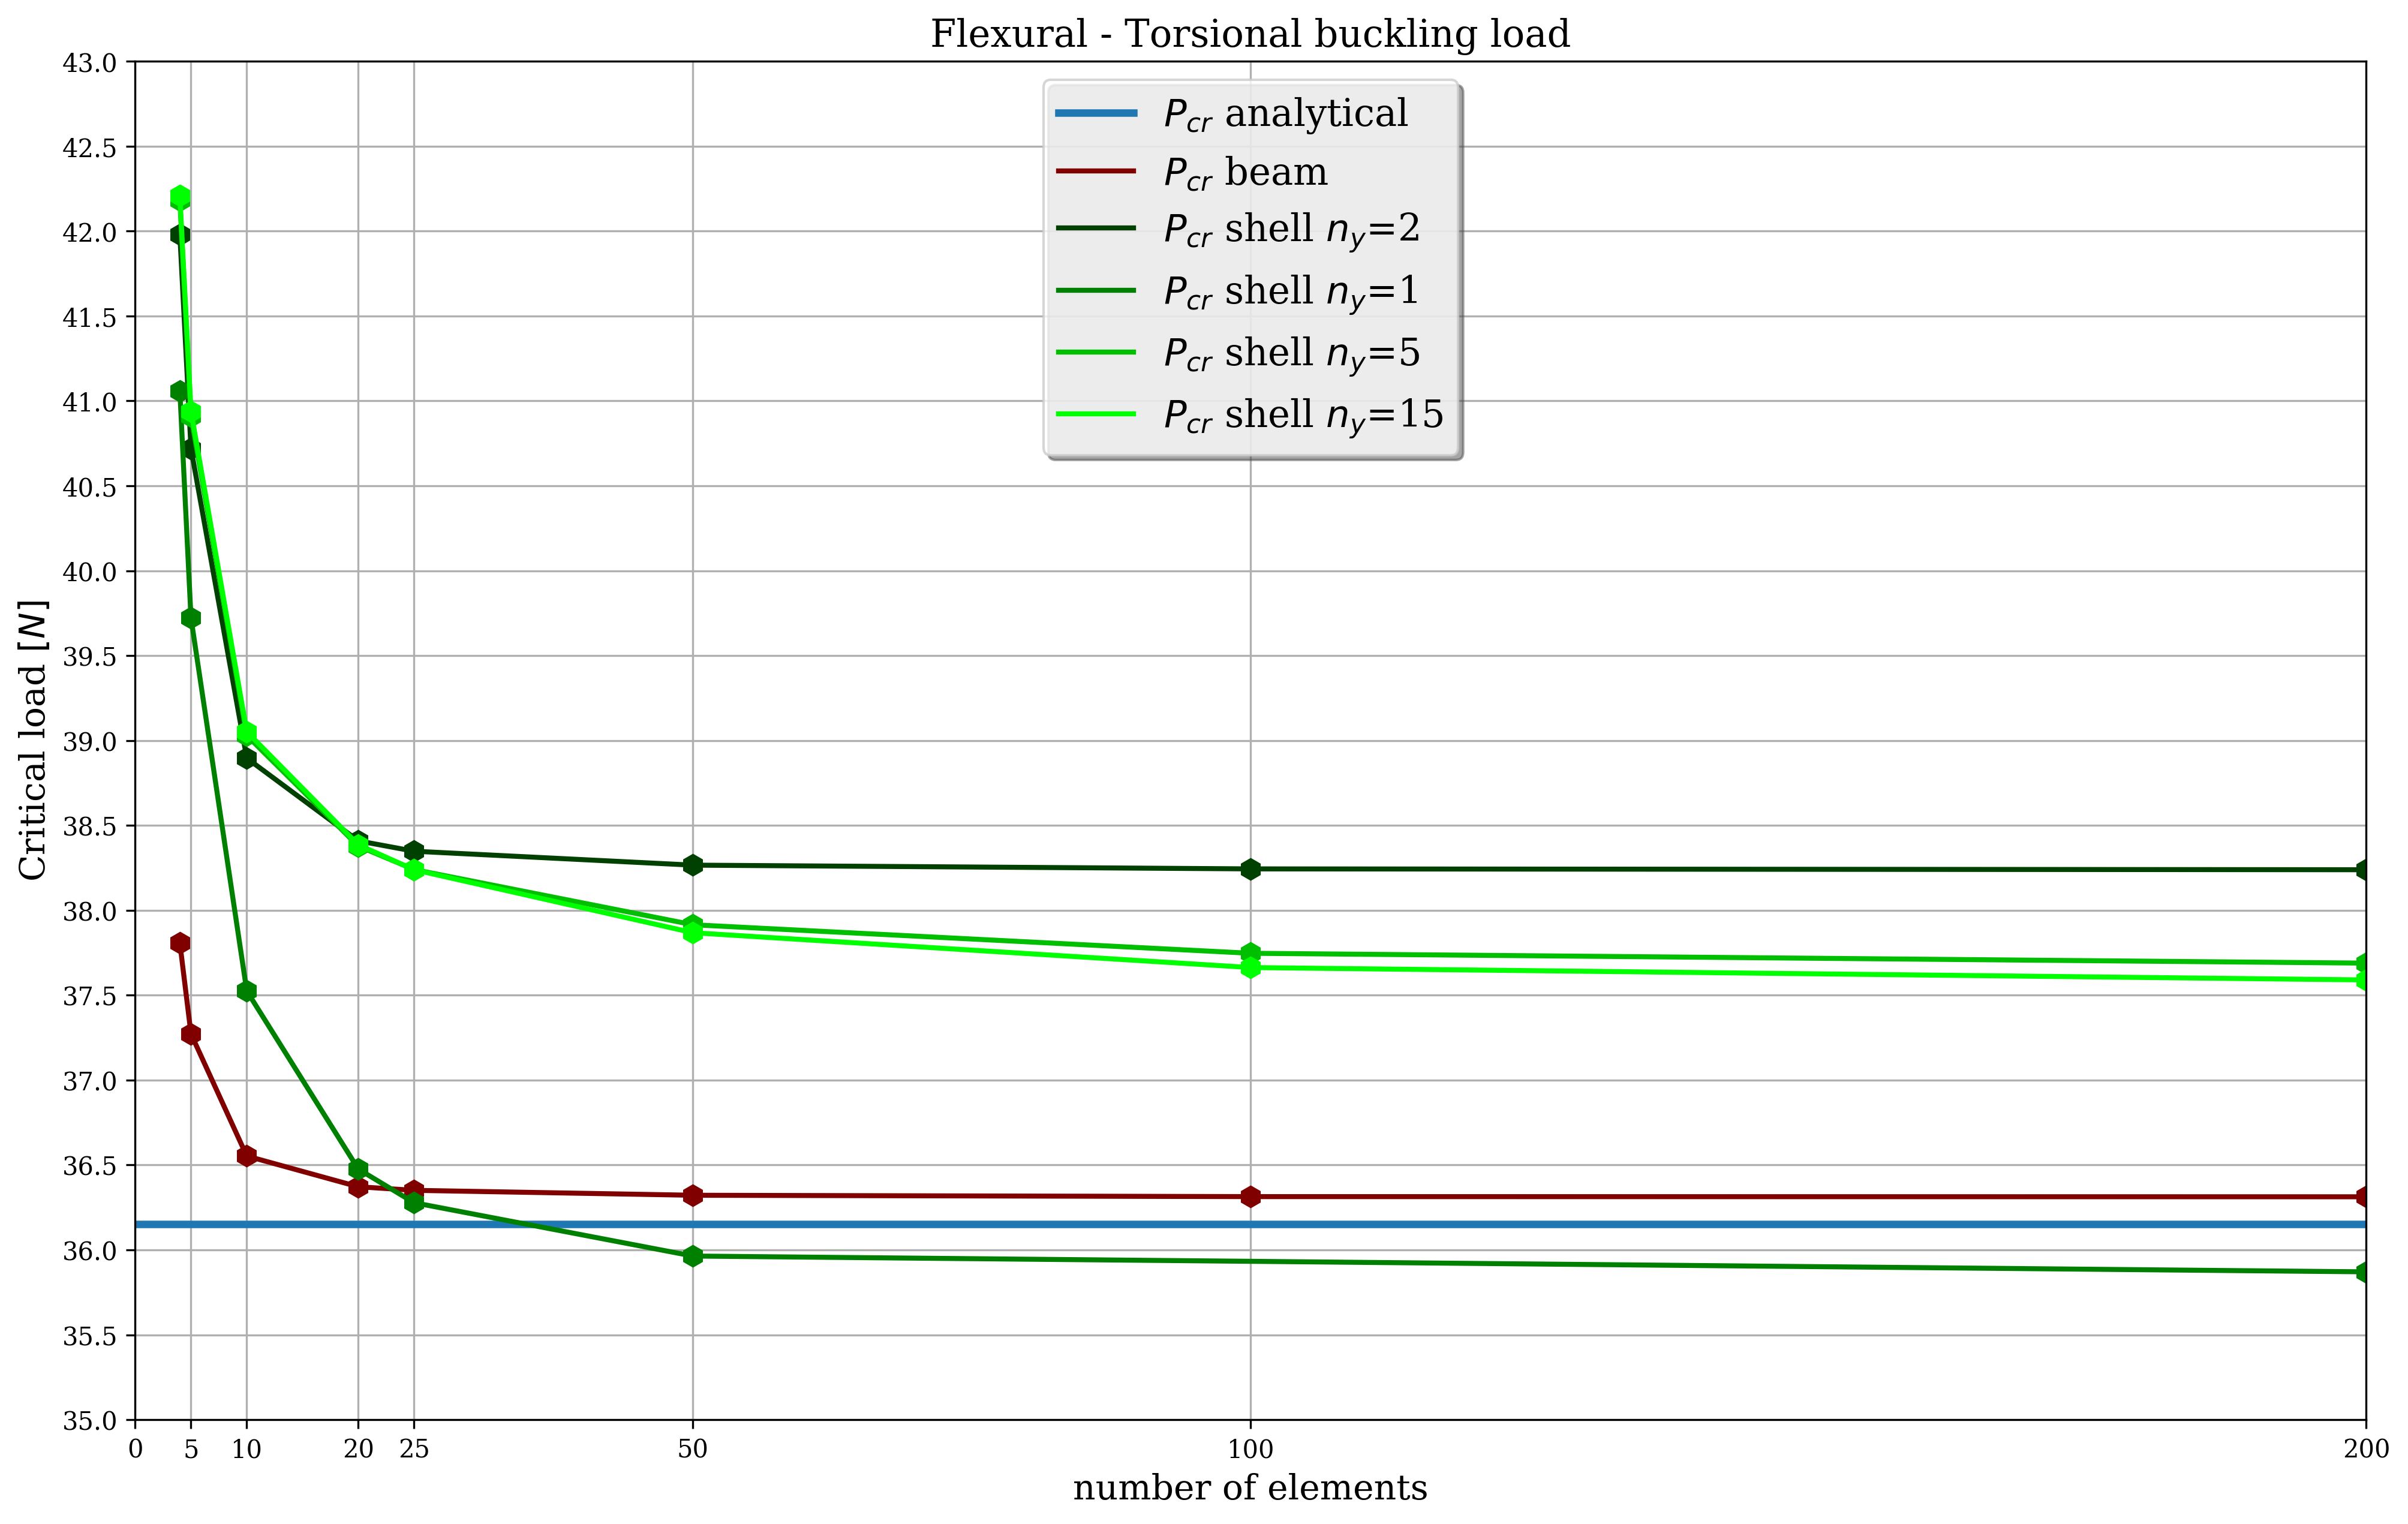

In [17]:
max_beam_el = np.max(beam_el)

max_shell_el = 0

for ye in shell_data:
    tmp_max = np.max(shell_data[ye][0])
    if tmp_max > max_shell_el:
        max_shell_el = tmp_max
        
max_el = max(max_shell_el, max_beam_el)

x_pcr = np.linspace(0,max_el,10)
y_pcr = Pcr*np.ones_like(x_pcr)

plt.figure(figsize=(16,10), dpi=300)

plt.plot(x_pcr,y_pcr, '-', lw=3, label='$P_{cr}$ analytical')

plt.plot(beam_el,beam_eig,'-', lw=2, color=(0.5,0.0,0.0), label="$P_{cr}$ beam")
plt.plot(beam_el,beam_eig,'h', ms=8, color=(0.5,0.0,0.0))

for i, ye in enumerate(shell_data):
    plt.plot(shell_data[ye][0],shell_data[ye][1],'-', lw=2, color=(0.0,(i+1)/len(shell_data),0.0), \
             label="$P_{cr}$ shell $n_y$="+str(ye)  )
    plt.plot(shell_data[ye][0],shell_data[ye][1],'h', ms=8, color=(0.0,(i+1)/len(shell_data),0.0) )


plt.xlim([0,max_el])
plt.ylim([np.floor(Pcr-1),np.ceil(Pcr+6)])
plt.xticks([0.0,5,10,20,25,50,100,200])
plt.yticks(np.arange(np.floor(Pcr-1),np.ceil(Pcr+6)+.1,.5))
plt.title('Flexural - Torsional buckling load',fontsize=15)
plt.xlabel(r'number of elements',fontsize=14)
plt.ylabel(r'Critical load $[N]$',fontsize=14)
plt.legend(loc='upper center', shadow=True,fontsize=15)
plt.grid()
plt.savefig('Lab06a.jpg')